In [1]:
%matplotlib inline
%env WORKDIR ~/Documents/weatherpy-work/

import sys
sys.path.append('..')

from wxdata import stormevents

import pandas as pd
import numpy as np

env: WORKDIR=~/Documents/weatherpy-work/


In [2]:
df = stormevents.tornadoes('2007-05-04 00:00', '2007-05-07 00:00', tz='CST')

In [22]:
eps_km = 60
eps_min = 60
min_samples = 15

In [23]:
clusters = stormevents.clust.st_clusters(df, eps_km, eps_min, min_samples)

In [24]:
clusters2 = stormevents.clust.st_clusters(df, eps_km, eps_min, min_samples, algorithm='brute')

In [25]:
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.basemap import Basemap
%matplotlib inline

# function courtesy http://qingkaikong.blogspot.com/2016/08/clustering-with-dbscan.html
def get_cmap(N, cmap_src):
    '''
    Returns a function that maps each index in 0, 1, ... N-1 to a distinct 
    RGB color.
    '''
    color_norm  = colors.Normalize(vmin=0, vmax=N-1)
    scalar_map = cm.ScalarMappable(norm=color_norm, cmap=cmap_src) 
    def map_index_to_rgb_color(index):
        return scalar_map.to_rgba(index)
    return map_index_to_rgb_color

def cluster_label(clust, color, outlier=False):
    if not outlier:
        time_part = '({}) {} to {} CST'.format(clust.index, clust.begin_time.strftime('%Y-%m-%d %H:%M'), 
                                          clust.end_time.strftime('%Y-%m-%d %H:%M'))
    else:
        time_part = 'outliers'
        
    clust_events = clust.events
    clust_events = clust_events[clust_events.event_type == 'Tornado']
    efs = stormevents.tors.ef(clust_events)
    
    ef_parts= ['EF{}: {}'.format(f, len(efs[efs == f])) for f in range(0, 6)]
    segments_part = '{} segments ({})'.format(len(clust_events), ', '.join(ef_parts))
    
    fats = clust_events.deaths_direct.sum()
    injs = clust_events.injuries_direct.sum()
    casualty_part = '{} fatalities | {} injuries'.format(fats, injs)
    
    return '\n'.join([time_part, segments_part, casualty_part])

def plot_clusters(basemap, clusters, title, cmap_src='gist_rainbow'):
    torclusters = {i: clust for i, clust in clusters.items() if i != stormevents.clust.NOISE_LABEL}
    noise = clusters[stormevents.clust.NOISE_LABEL]
    legend_handles = []
    
    colors = get_cmap(len(torclusters), cmap_src)
    shadow = path_effects.withSimplePatchShadow(offset=(1, -1))
    
    for clust in sorted(torclusters.values(), key=lambda cl: cl.begin_time):
        color = colors(clust.index)
        clust.plot(basemap, markersize=1.5, color=color, path_effects=[shadow])
        legend_handles.append(mpatches.Patch(color=color, label=cluster_label(clust, color)))

    noise.plot(basemap, markersize=1.5, color='gray', path_effects=[shadow])
    legend_handles.append(mpatches.Patch(color='gray', 
                                         label=cluster_label(noise, 'gray', outlier=True)))

    plt.legend(handles=legend_handles, loc=2)
    plt.title(title, fontsize=20)

    ax = fig.axes[0]
    plt.text(0.99, 0.01, 'Graphic created by Jim Tang (@wxmann)', transform=ax.transAxes, fontsize=16,
            verticalalignment='bottom', horizontalalignment='right', 
            bbox=dict(alpha=0.75, facecolor='white', edgecolor='gray'))
    plt.show()

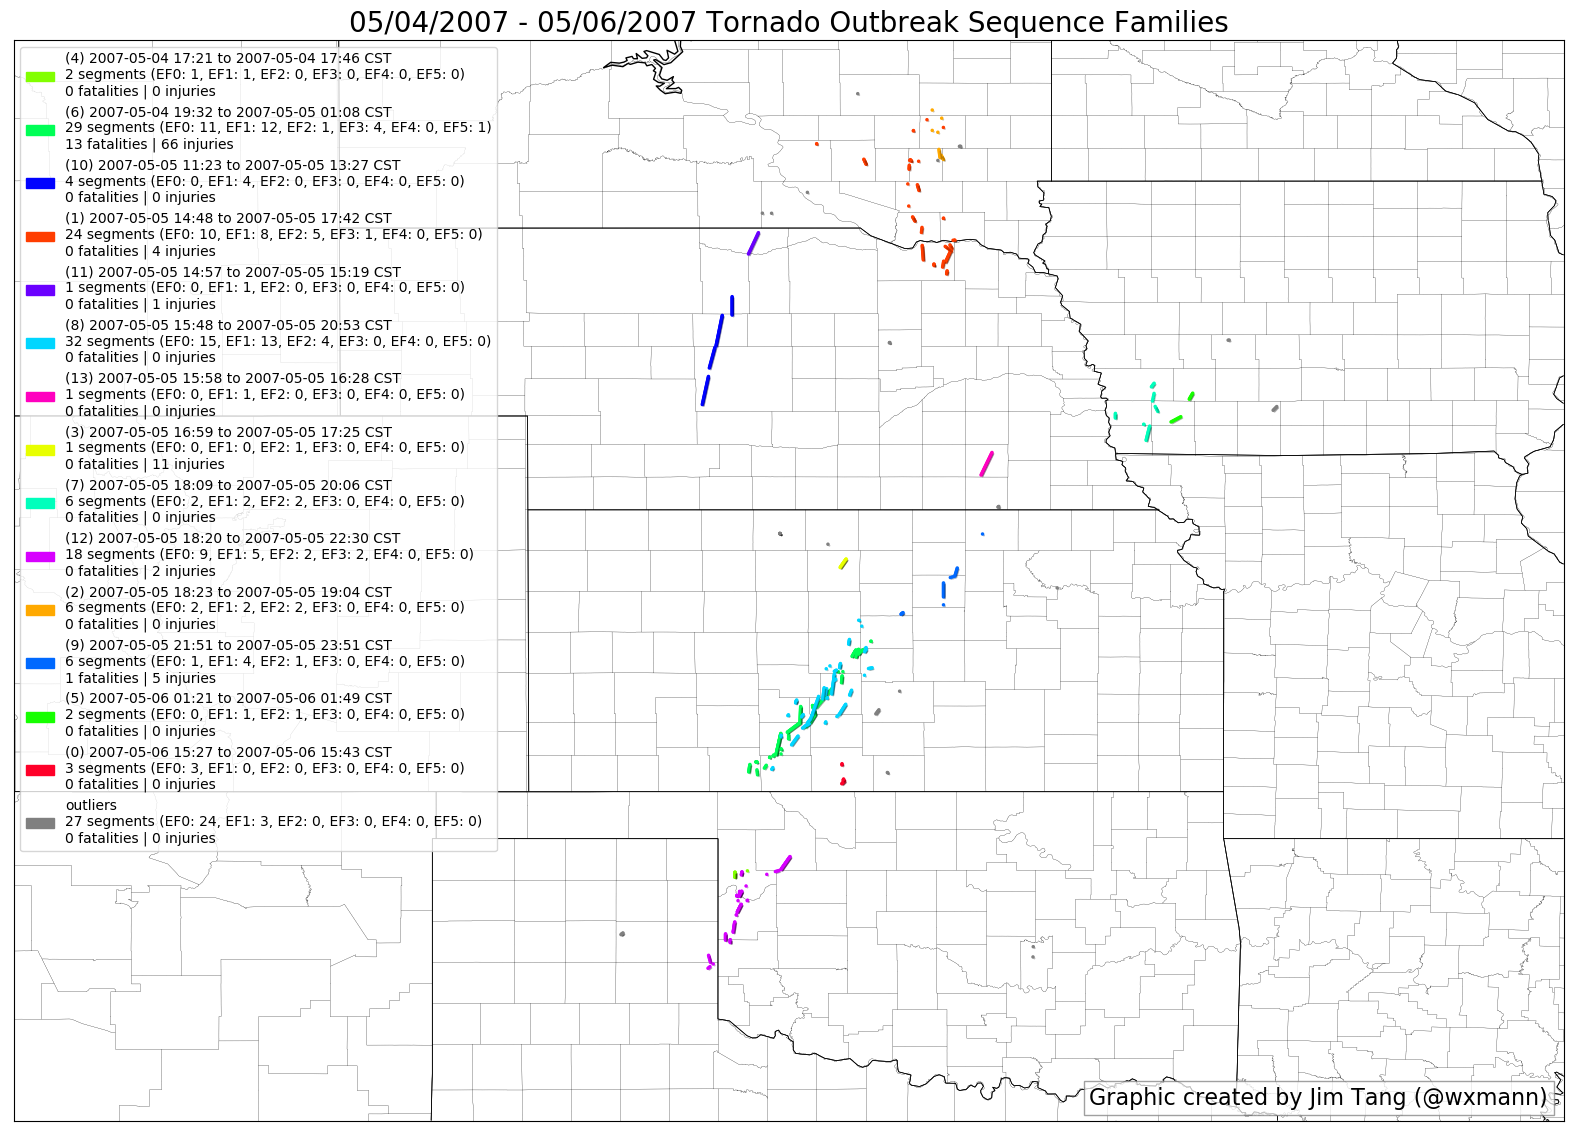

In [26]:
fig = plt.figure(figsize=(20, 20), dpi=100)
    
# 5/4/03
# llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat = -102, -85.5, 33.5, 44

llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat = -107.5, -91, 33.5, 45
m = Basemap(projection='cyl', 
            llcrnrlon=llcrnrlon, llcrnrlat=llcrnrlat, urcrnrlon=urcrnrlon, urcrnrlat=urcrnrlat,
            resolution='i',area_thresh=1000)

m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.drawcounties()

plot_clusters(m, clusters, '05/04/2007 - 05/06/2007 Tornado Outbreak Sequence Families')

In [27]:
assert len(clusters) == len(clusters2)
clusters_by_time = sorted(clusters.values(), key=lambda cl: cl.begin_time)
clusters2_by_time = sorted(clusters2.values(), key=lambda cl: cl.begin_time)

noise = clusters[stormevents.clust.NOISE_LABEL]
noise2 = clusters2[stormevents.clust.NOISE_LABEL]

assert noise == noise2
for clust, clust2 in zip(clusters_by_time, clusters2_by_time):
    assert clust == clust2
    
print('Test passed!')

Test passed!
